Author: Andres Felipe Alba Hernandez
Applied AI Engineer <br>
April 2020 <br>
email: v-analba@microsoft.com <br>
https://www.linkedin.com/in/ahandresf/

In [1]:
#Importing the class for the different data-driven models
#Note: You should train the model before using them here. 
from predictor import ModelPredictor

Using TensorFlow backend.


In [2]:
#importing parameters used during training
from conf_params_datadriven import STATE_SPACE_DIM, ACTION_SPACE_DIM, MARKOVIAN_ORDER, POLYNOMIAL_DEGREE, DROPOUT_RATE

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300

# Loading data to analize

### Get action and states names

In [4]:
#Asuming the states_names and action names where store in env_data directory
short_actions = './his_data/short_actions.npy'
short_states = './his_data/short_states.npy'

state_names = np.load(short_states, allow_pickle=True)
action_names = np.load(short_actions, allow_pickle=True)

In [5]:
num_states=state_names.shape[0]
num_actions=action_names.shape[0]
print(state_names.shape)
print(action_names.shape)

(9,)
(4,)


### Load input-output dataset

In [6]:
INPUT_DATASET='./his_data/short_x_cut.pickle'
OUTPUT_DATASET='./his_data/short_y_cut.pickle'

### Load trained model

In [7]:
#model_stamp = 'May_18_142049'
model_stamp = 'May_19_154922'

# Generate validation dataset


In [8]:
# Model to use
print("Neuronal Network model")
print('Model Stamp:',model_stamp)
predictor=ModelPredictor(modeltype='nn', noise_percentage=0, action_space_dim=ACTION_SPACE_DIM,
                          state_space_dim=STATE_SPACE_DIM,model_stamp=model_stamp)

Neuronal Network model
Model Stamp: May_19_154922
nn  is used as the data driven model to train brain.








General function

# Trace Validation

In [9]:
import pickle
#input and output dataset were define at earlier in this notebook
with open(INPUT_DATASET, 'rb') as f:
    input_training = pickle.load(f)
    print("I load x_set from:",INPUT_DATASET)
with open(OUTPUT_DATASET, 'rb') as f:
    output_training = pickle.load(f)
    print("I load y_set FROM",OUTPUT_DATASET)
    
#Unpack actions and states
#x_set_total = np.concatenate((actions_input,states_input),axis=1)
actions_input=input_training[:,0:num_actions]
states_input=input_training[:,num_actions::]
print(actions_input.shape)
print(states_input.shape)
print(output_training.shape)

I load x_set from: ./his_data/short_x_cut.pickle
I load y_set FROM ./his_data/short_y_cut.pickle
(414716, 4)
(414716, 9)
(414716, 9)


In [10]:
a=actions_input[0,:]
s=states_input[0,:]
print(a.shape)
print(s.shape)

(4,)
(9,)


In [11]:
def get_predict_step_trace(predictor,states_input,actions_trace):
    #predictor=nn_predictor
    input_s = states_input[0,:]
    state_estimation=[]
    for observation in range(0,len(actions_trace)):
        input_s = states_input[observation,:] #get input from dataset
        state = predictor.predict(state=input_s,action=actions_trace[observation,:]) #estimate diff or state
        state_estimation.append(state) #add result to the trace
    state_estimation=np.array(state_estimation) #convert list into numpy array
    print('state_estimation shape: %s',state_estimation.shape)
    return(state_estimation)

In [12]:
output_estimation=get_predict_step_trace(predictor=predictor,
                                         states_input=states_input, 
                                         actions_trace=actions_input)

state_estimation shape: %s (414716, 9)


# Accuracy from the training

Lets test against the whole dataset to get accuracy.

In [13]:
y_true=output_training
y_pred=output_estimation
print('y_true:',y_true.shape)
print('y_pred:',y_pred.shape)

y_true: (414716, 9)
y_pred: (414716, 9)


In [26]:
y_true=check_array(y_true)
y_pred=check_array(y_pred)
diff = np.abs(y_true - y_pred)


3649324
3732444


In [40]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true=check_array(y_true)
    y_pred=check_array(y_pred)
    diff = np.abs(y_true - y_pred)
    den=np.abs(y_true)
    rows,columns=y_true.shape
    mape=np.zeros(columns,)
    print(np.count_nonzero(y_true))
    print(y_true.shape[0]*y_true.shape[1])
    for col in range(columns):
        #print(col)
        error_percentage=[]
        for row in range(rows):
            if y_true[row,col]!=0:
                error_percentage.append(diff[row,col]/den[row,col])
        err_p=np.array(error_percentage)
        mape[col]=err_p.mean()
    return(mape)
mape=mean_absolute_percentage_error(y_true,y_pred)

3649324
3732444


In [45]:
print(mape.shape)
for p in mape:
    print(int(p))
    

(9,)
17
3
0
9
486600162141374
155
10
9809838886555196
14


In [49]:
import sklearn.metrics
mae=sklearn.metrics.mean_absolute_error(y_true,y_pred,multioutput='raw_values')
print(mae)

[4.11009867e-01 5.11284161e+01 5.41668650e+00 9.60440486e+02
 4.83296350e+01 5.33860037e+01 8.39914528e+01 4.12070859e+02
 7.52399992e+02]


In [71]:
def get_max_err(y_true,y_pred):
    rows,columns=y_true.shape
    #iterate by feature
    max_error=[]
    mean_y_t=[]
    for col in range(columns):
        y_t=y_true[:,col]
        y_p=y_pred[:,col]
        me=y_t.mean()
        e=sklearn.metrics.max_error(y_t,y_p)
        max_error.append(e)
        mean_y_t.append(me)
    return(np.array(max_error),np.array(mean_y_t))

In [73]:
max_error,mean_y_t=get_max_err(y_true,y_pred)
max_err_scale=max_error/mean_y_t
print(max_error)
print(mean_y_t)
print(max_err_scale)

[2.46066749e+00 1.10296083e+02 1.81299309e+02 1.13263611e+05
 9.99807358e+01 9.54887085e+01 1.06396327e+03 2.21350597e+03
 5.71415210e+03]
[2.70757360e-01 8.02947409e+01 7.31768218e+01 1.04032427e+02
 4.75668386e+01 1.87014702e+01 5.14765015e+02 1.50790212e+03
 3.95355274e+03]
[   9.08809084    1.37364019    2.47755102 1088.7337206     2.10189995
    5.1059466     2.06689119    1.46793744    1.44532082]


In [ ]:
#see that this is a hard code path, change it depending what do you want to analize
print(nn_filename)
show_accuracy(nn_filename)

In [ ]:
def get_stats(accuracy):
    maximum = accuracy.max()
    minimum = accuracy.min()
    mean = accuracy.mean()
    std = accuracy.std()
    print("/nGeneral Stadistics\n")
    print(('max accuracy:%s\nmin accuracy:%s\naverage accuracy:%s\nstandard desviation:%s\n')%(maximum,minimum,mean,std))
    return (maximum,minimum,mean,std)

In [ ]:
def plot_accuracy_bars(features_names,accuracy,store_plot=False):
    minimum=accuracy.min()
    plt.xlabel('Accuracy')
    plt.ylabel('Features')
    plt.xlim(minimum-0.1, 1)
    plt.tick_params(labelsize=6)
    plt.barh(features_names,accuracy)
    plt.show()

In [ ]:
def show_accuracy(accuracy_filename):
    res=np.load(accuracy_filename)
    print('shape of accuracy',res.shape)
    print('shape of state_names',state_names.shape)
    maximum,minimum,mean,std = get_stats(res)
    if len(state_names)>15:
        print("Show accuracy direclty")
        plot_accuracy_bars(features_names=state_names[0:14],accuracy=res[0:14])
        plot_accuracy_bars(features_names=state_names[15::],accuracy=res[15::])
    else:
        print("Show accuracy direclty")
        plot_accuracy_bars(features_names=state_names,accuracy=res)

# Plots by traces

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300
import pickle
#PLOT TRACES
def plot_results(estimate_trace,real_trace,title="Non title provided"):
    plt.plot(estimate_trace,label='Predictive trace')
    plt.plot(real_trace,label='Real trace',linewidth=0.3)
    #plt.plot(real_trace,'*',label='Real trace')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_all_traces(predictor_trace, real_trace, title):
    for column in range(num_states):
        subtitle=title+' column:'+str(column)
        plot_results(estimate_trace=predictor_trace[:,column],real_trace=real_trace[:,column],title=subtitle)


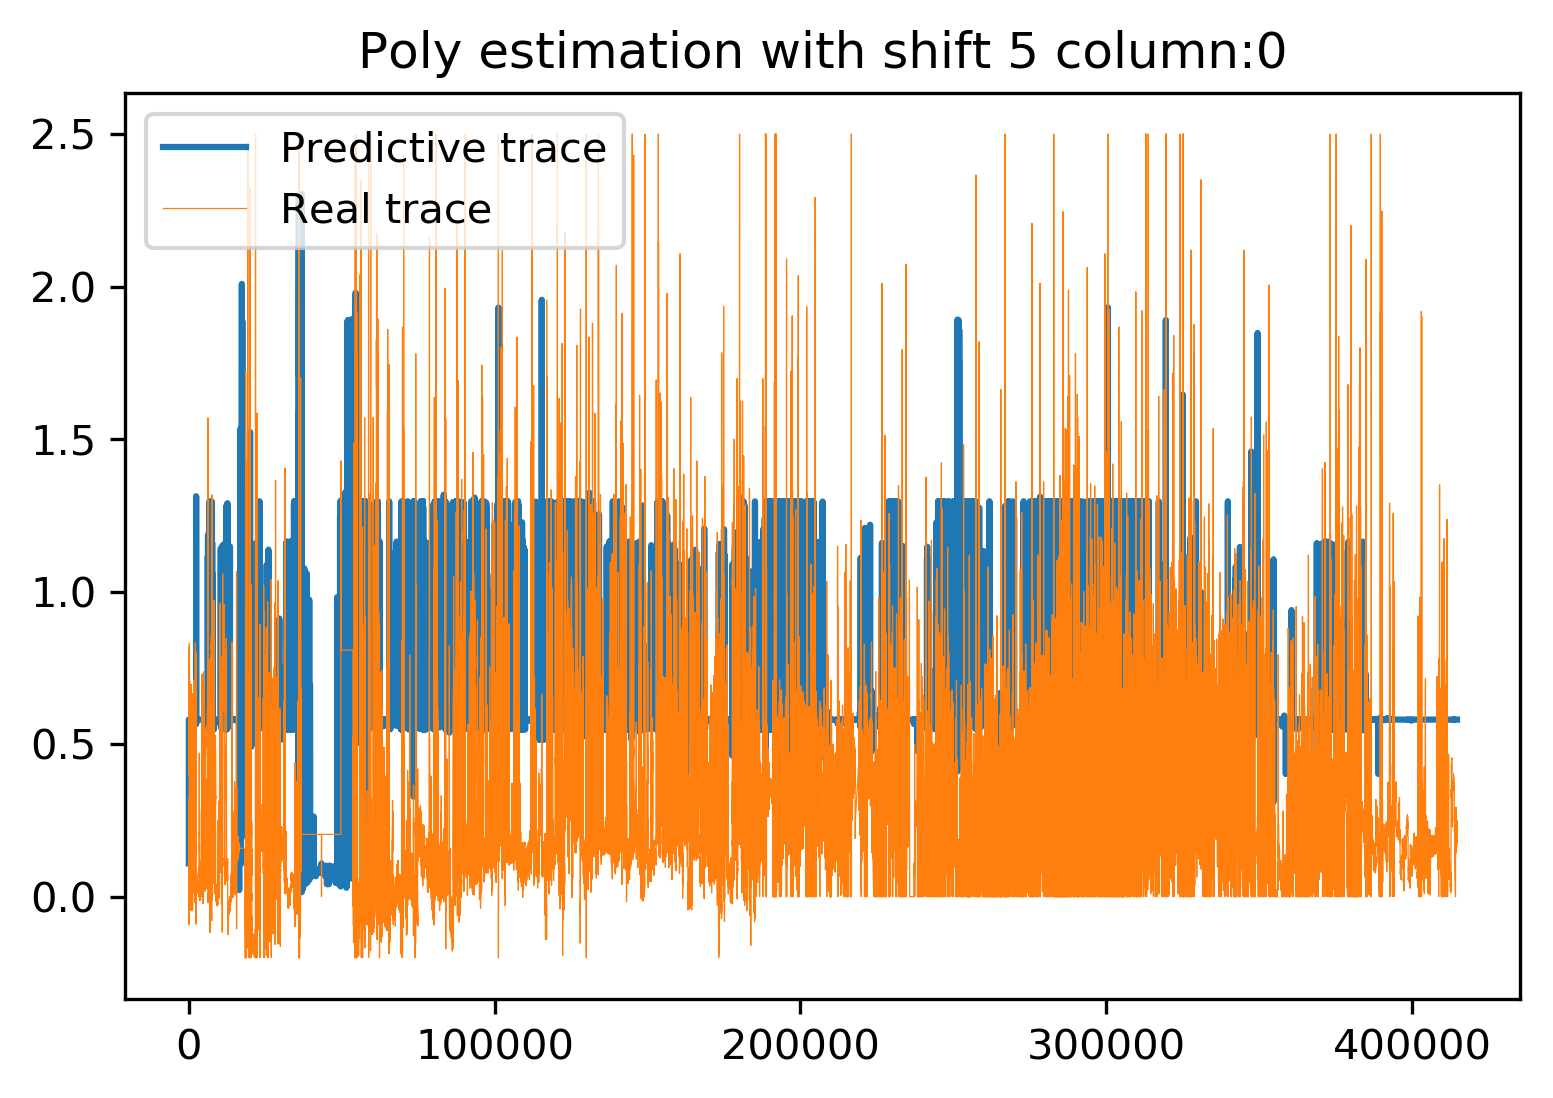

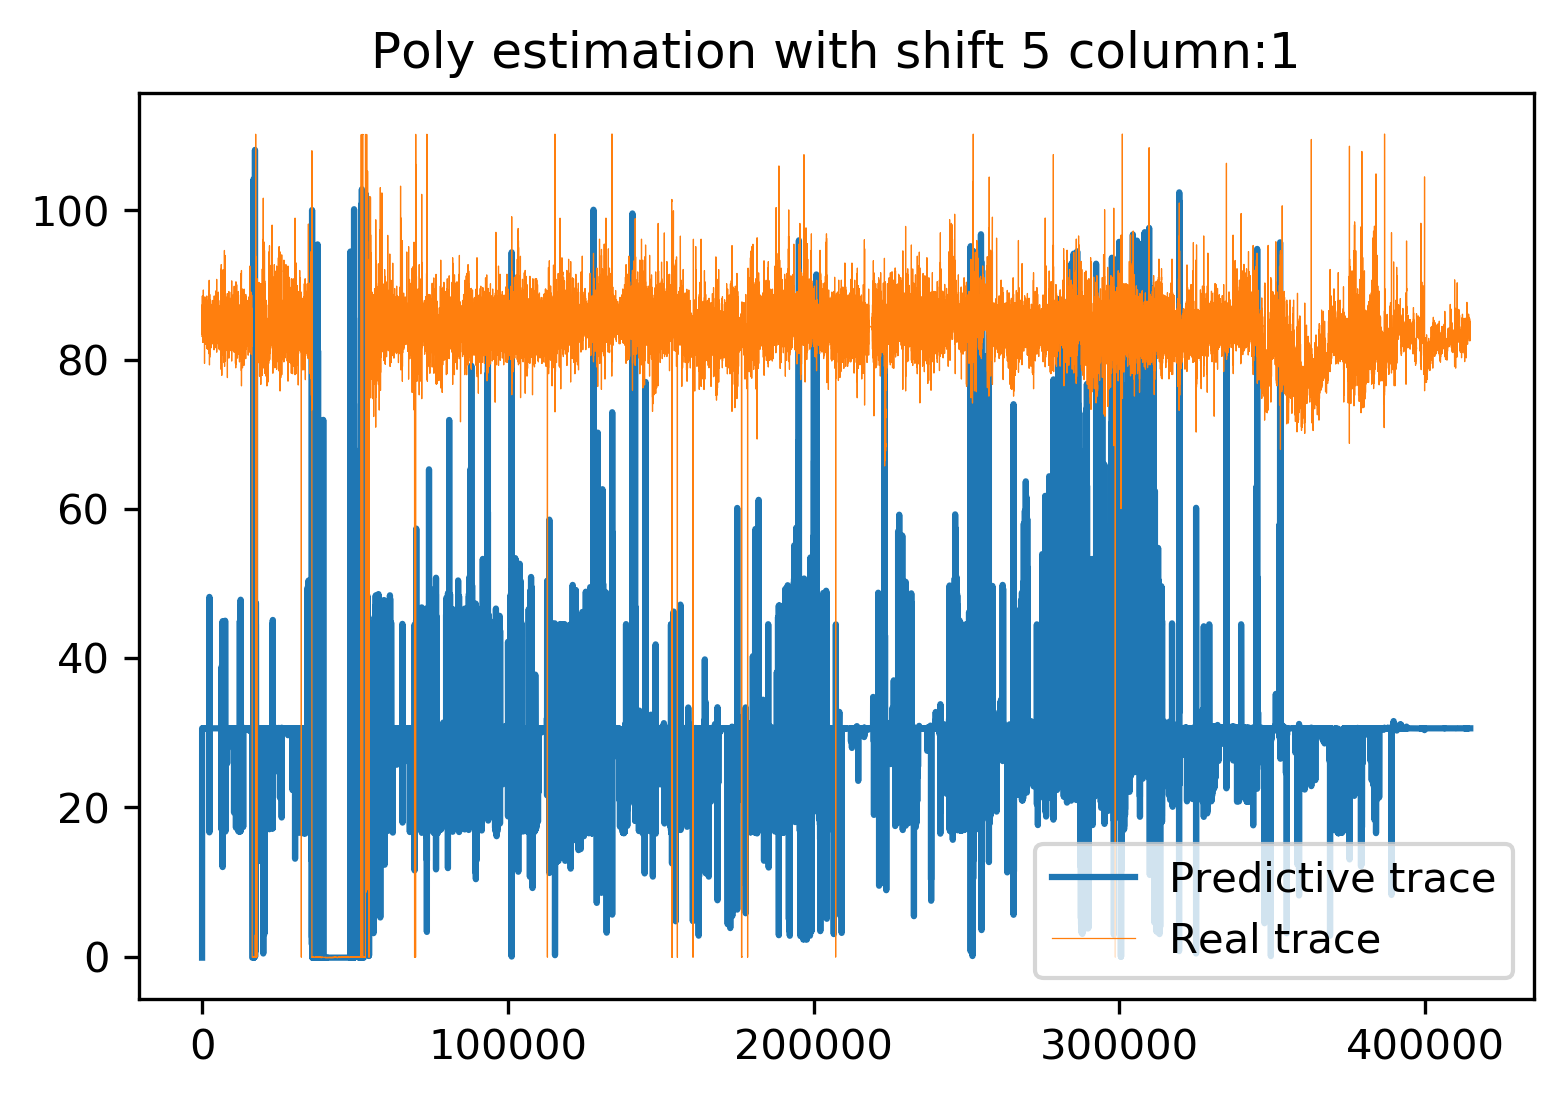

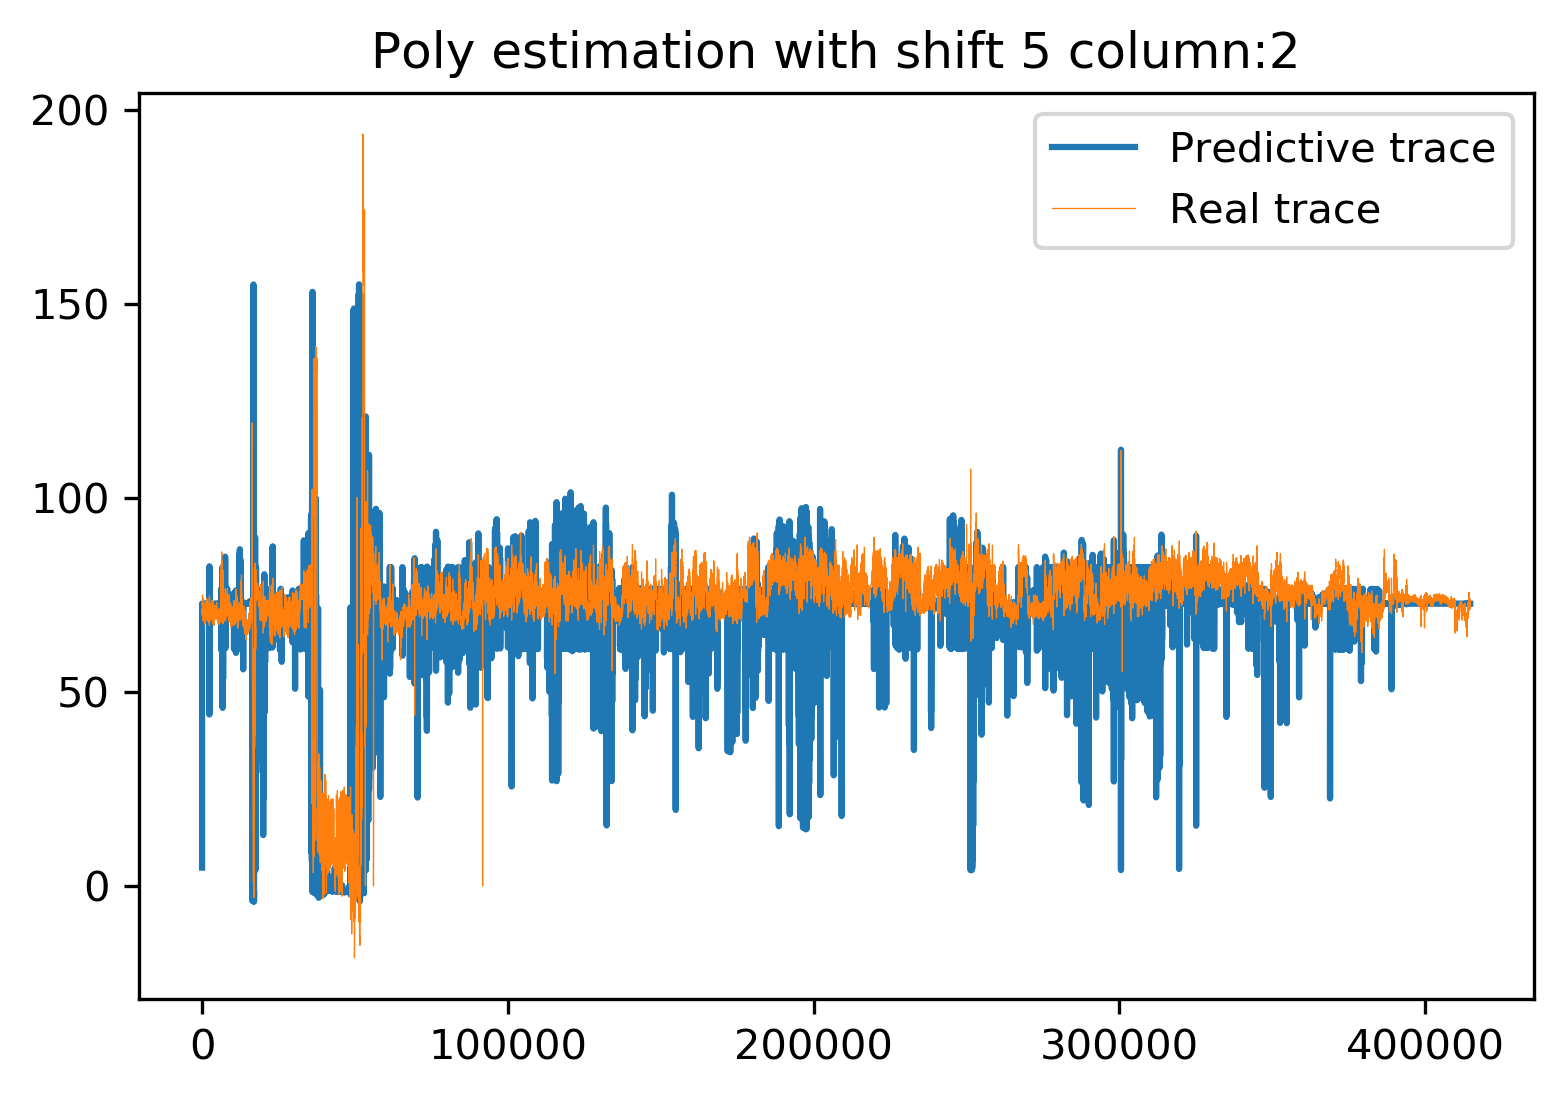

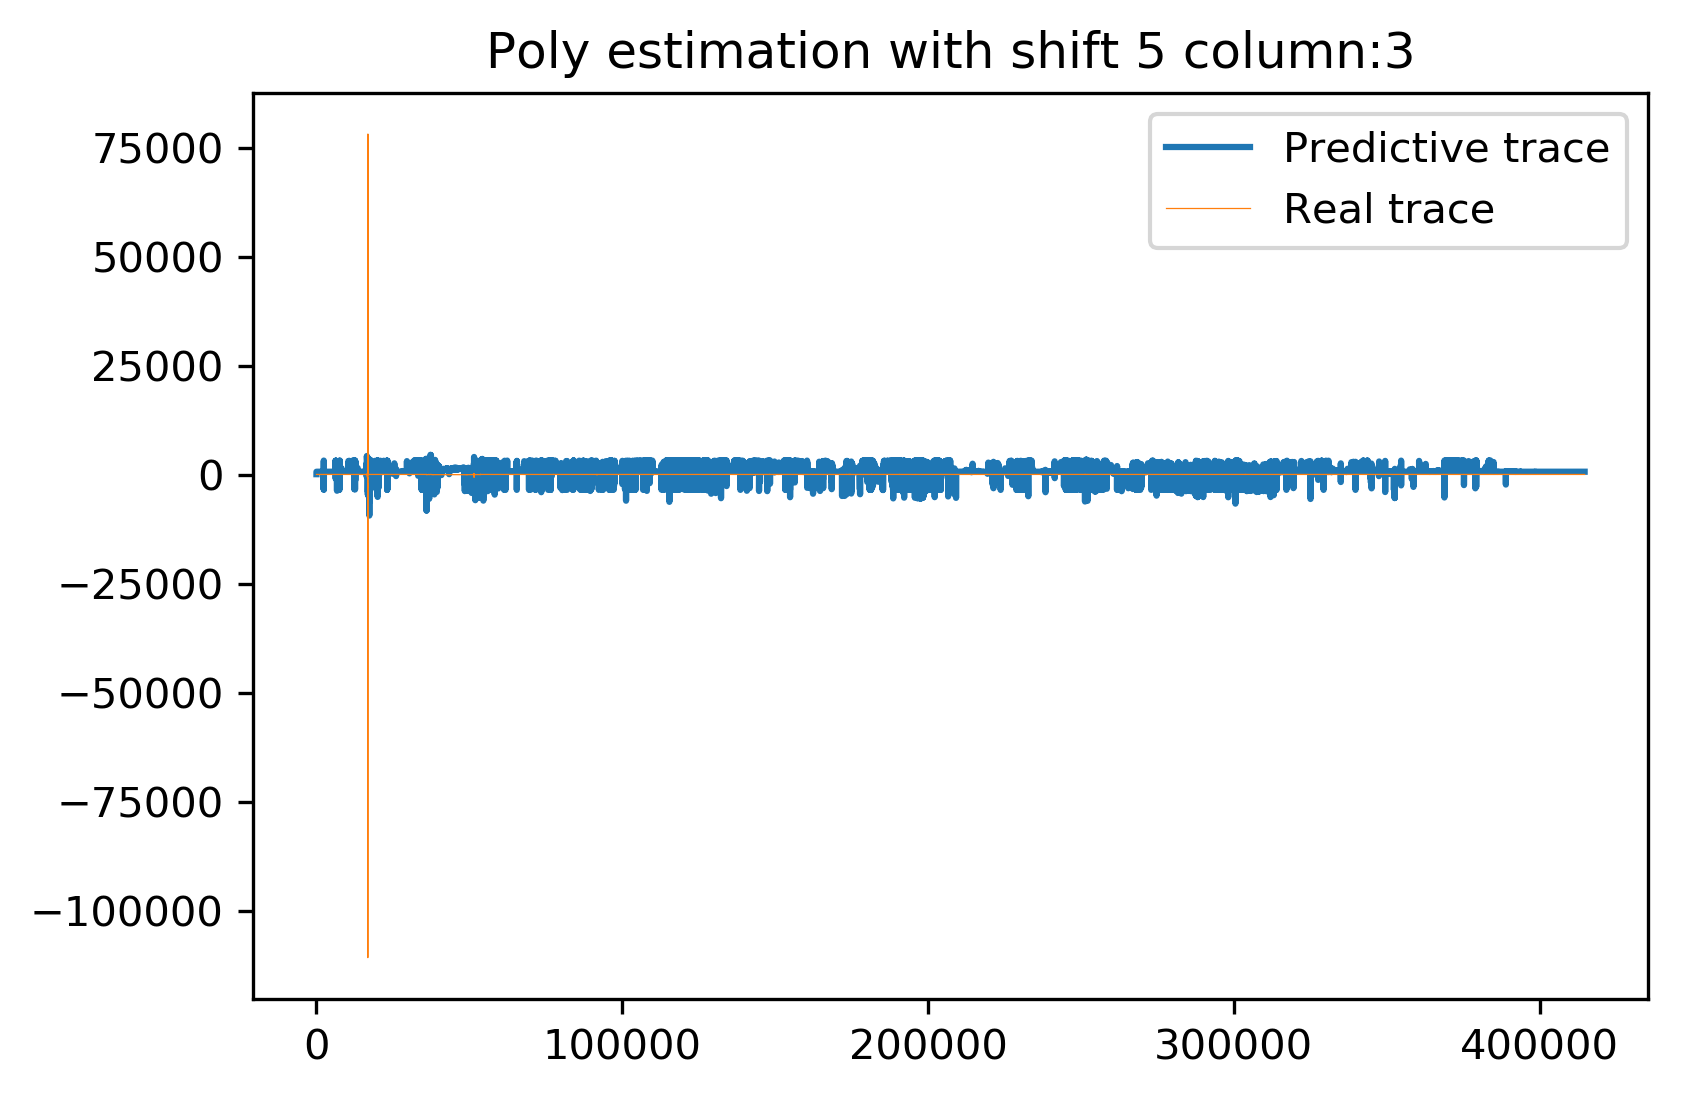

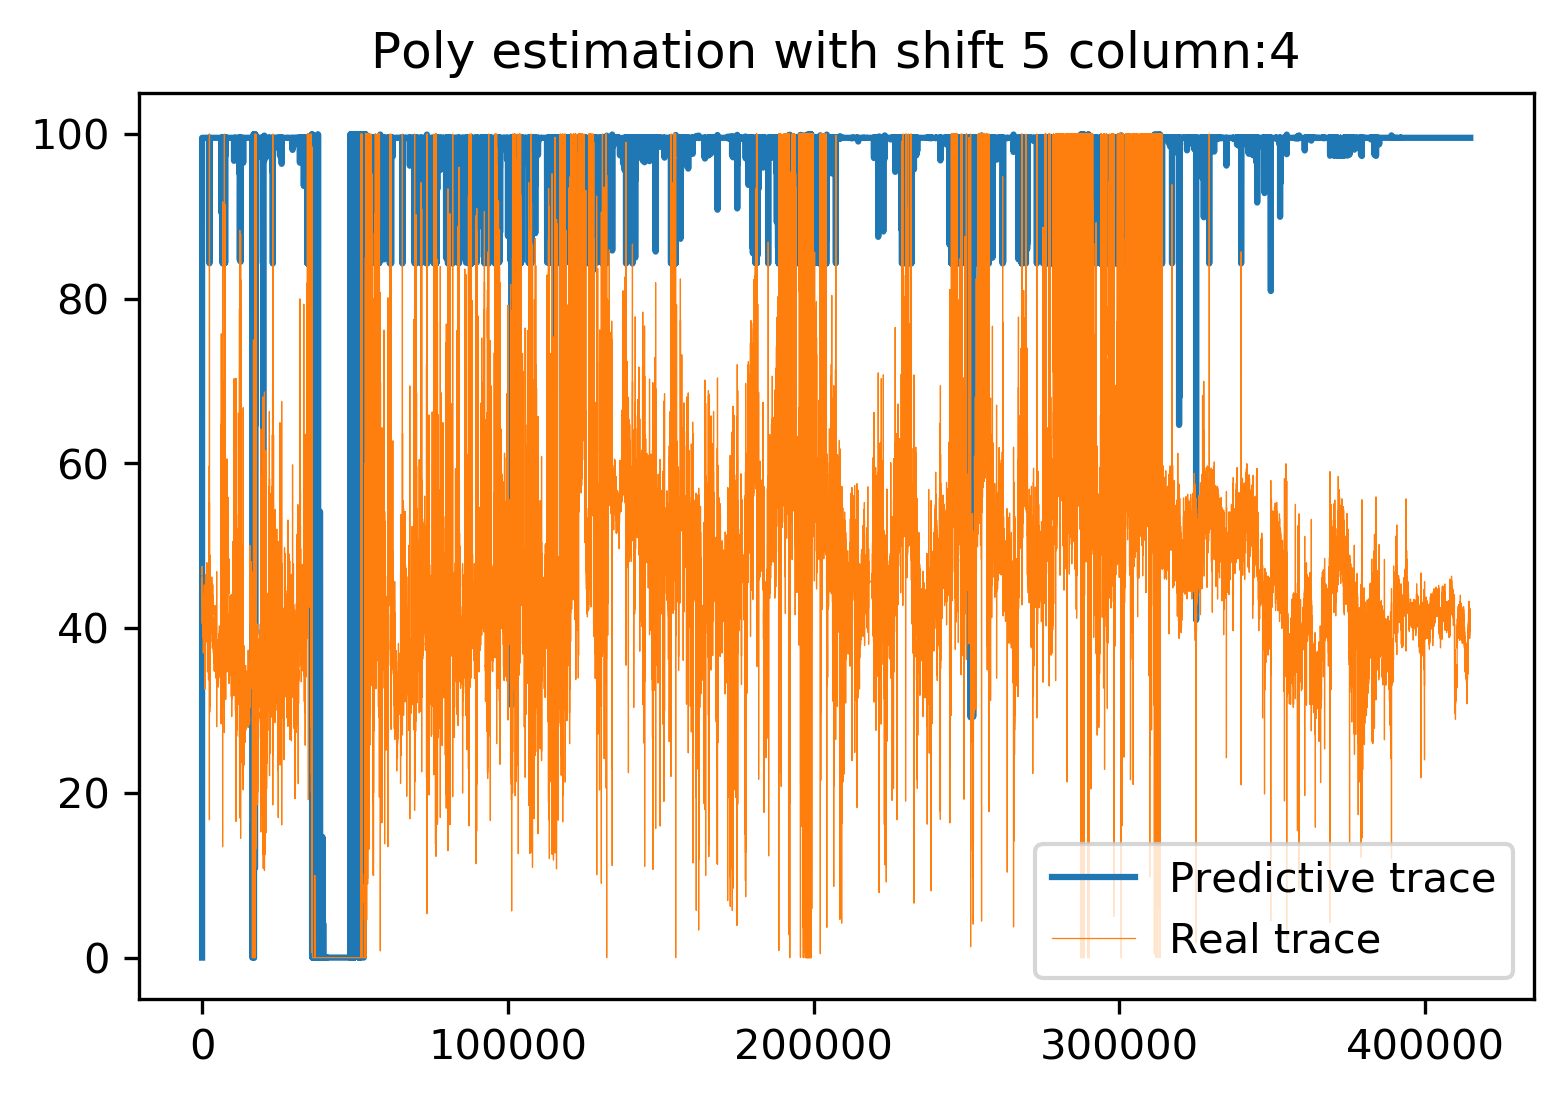

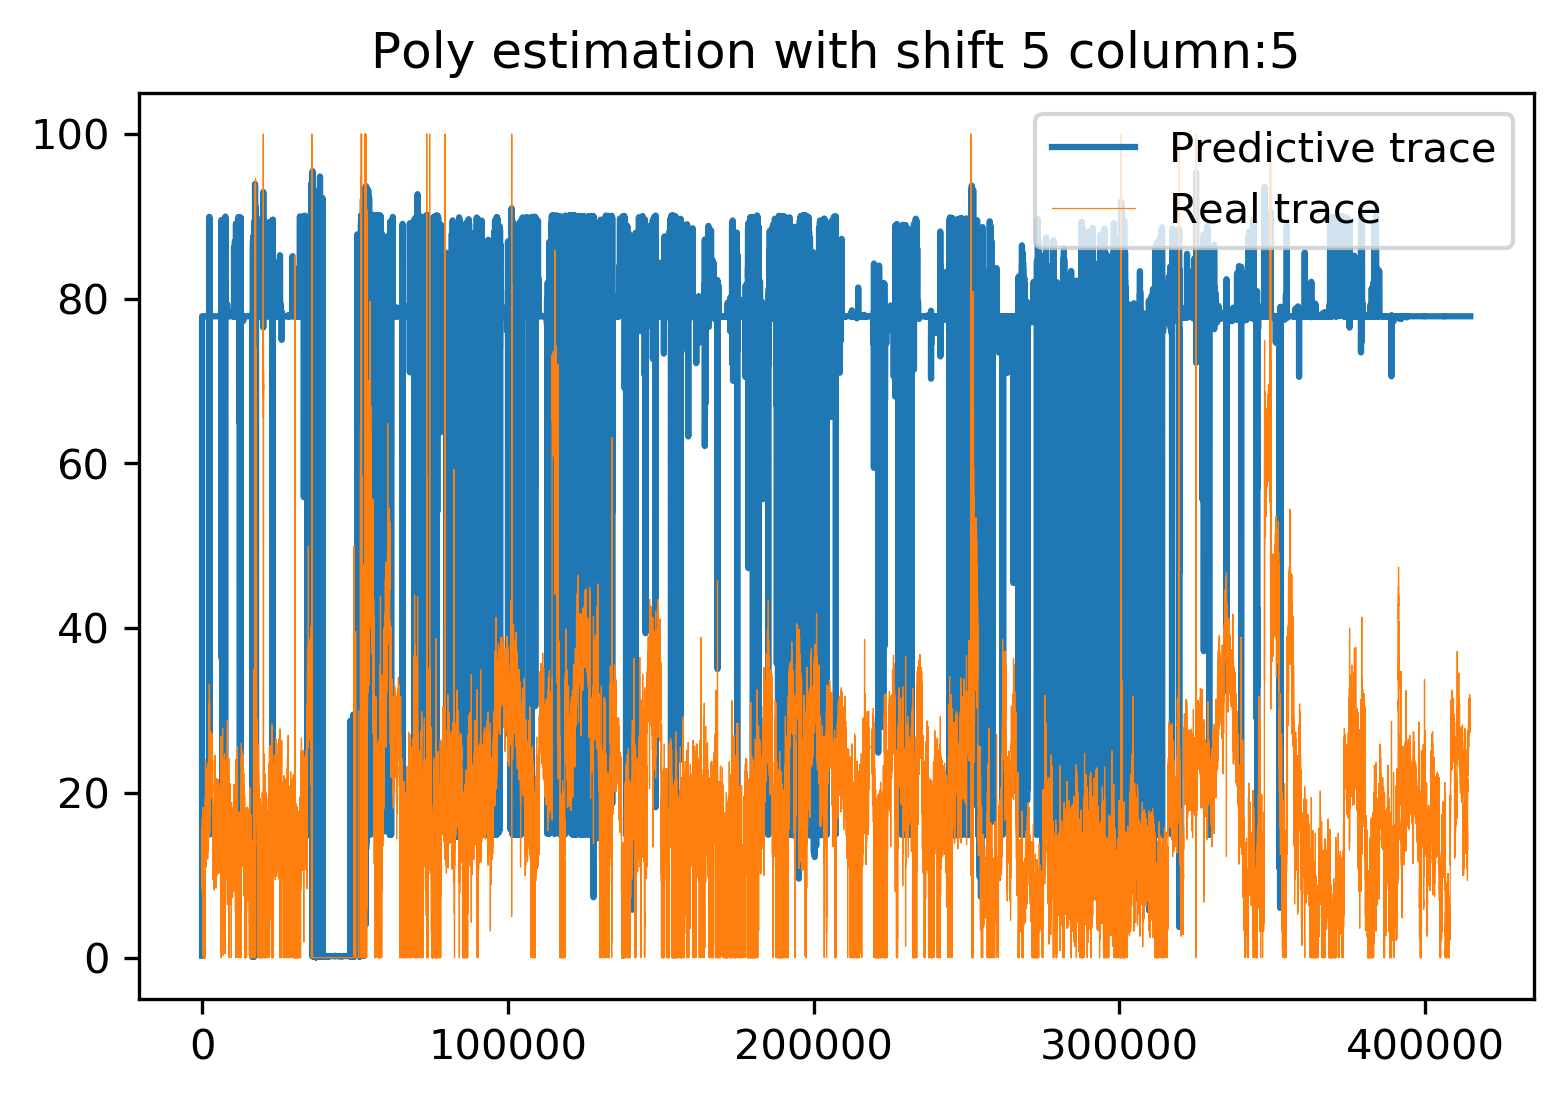

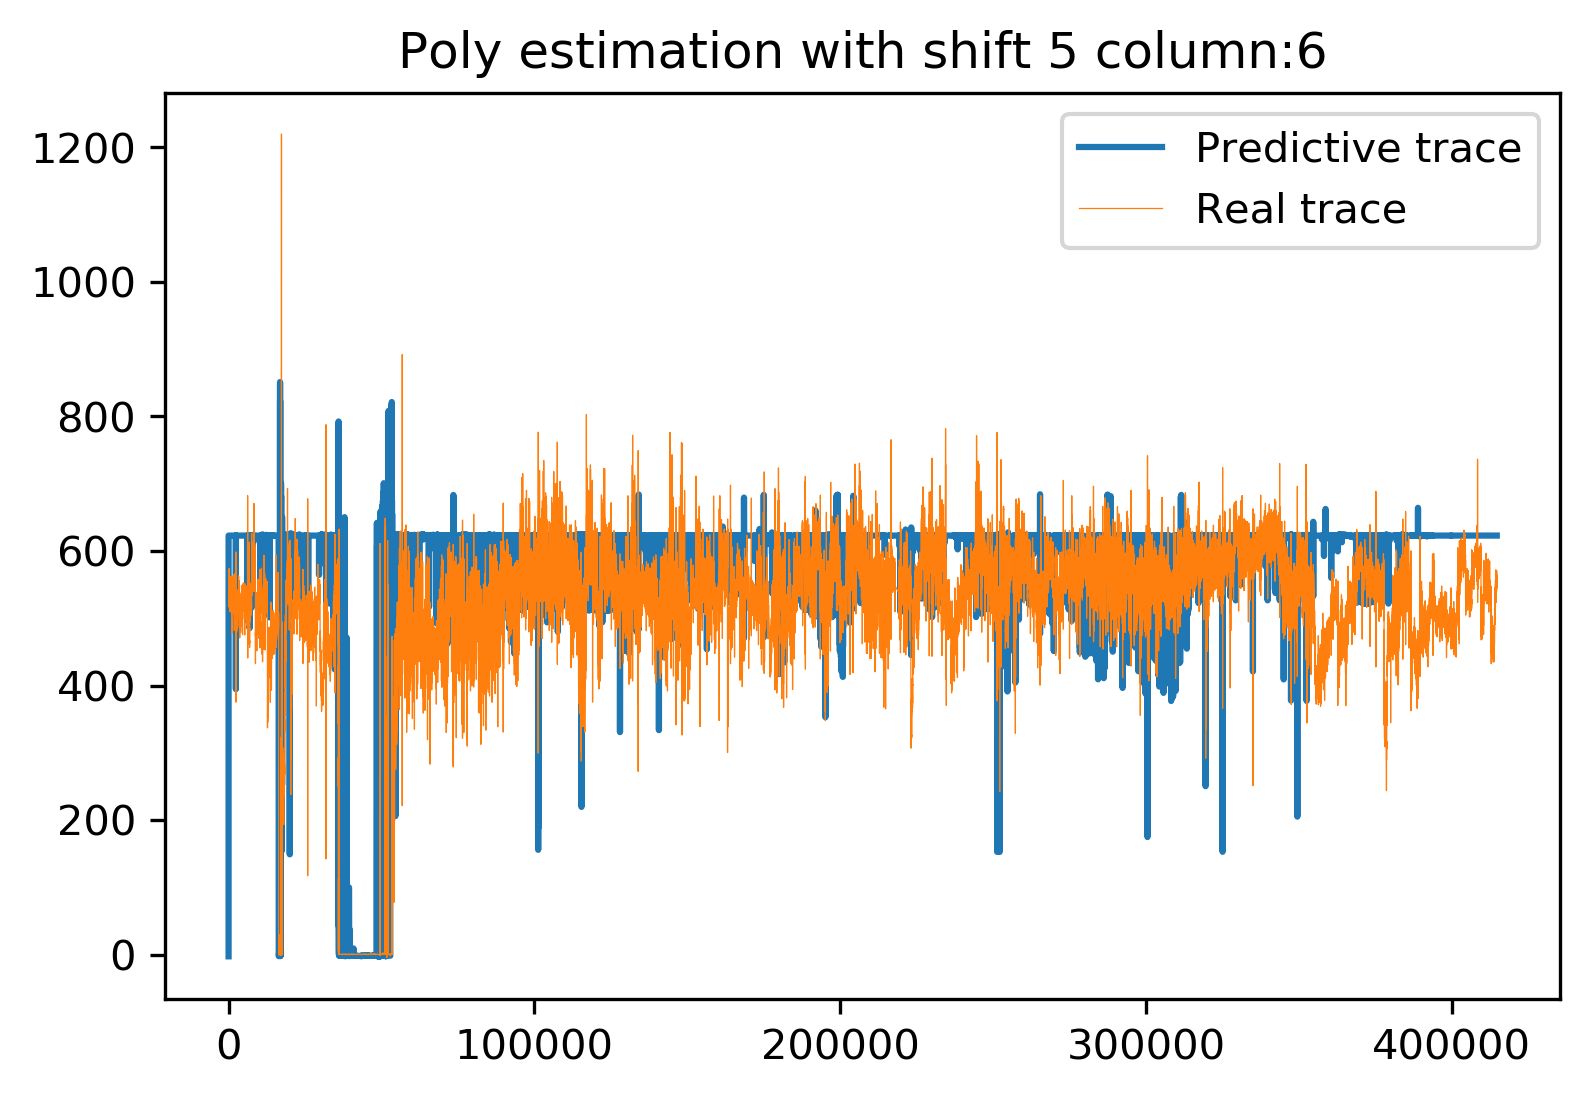

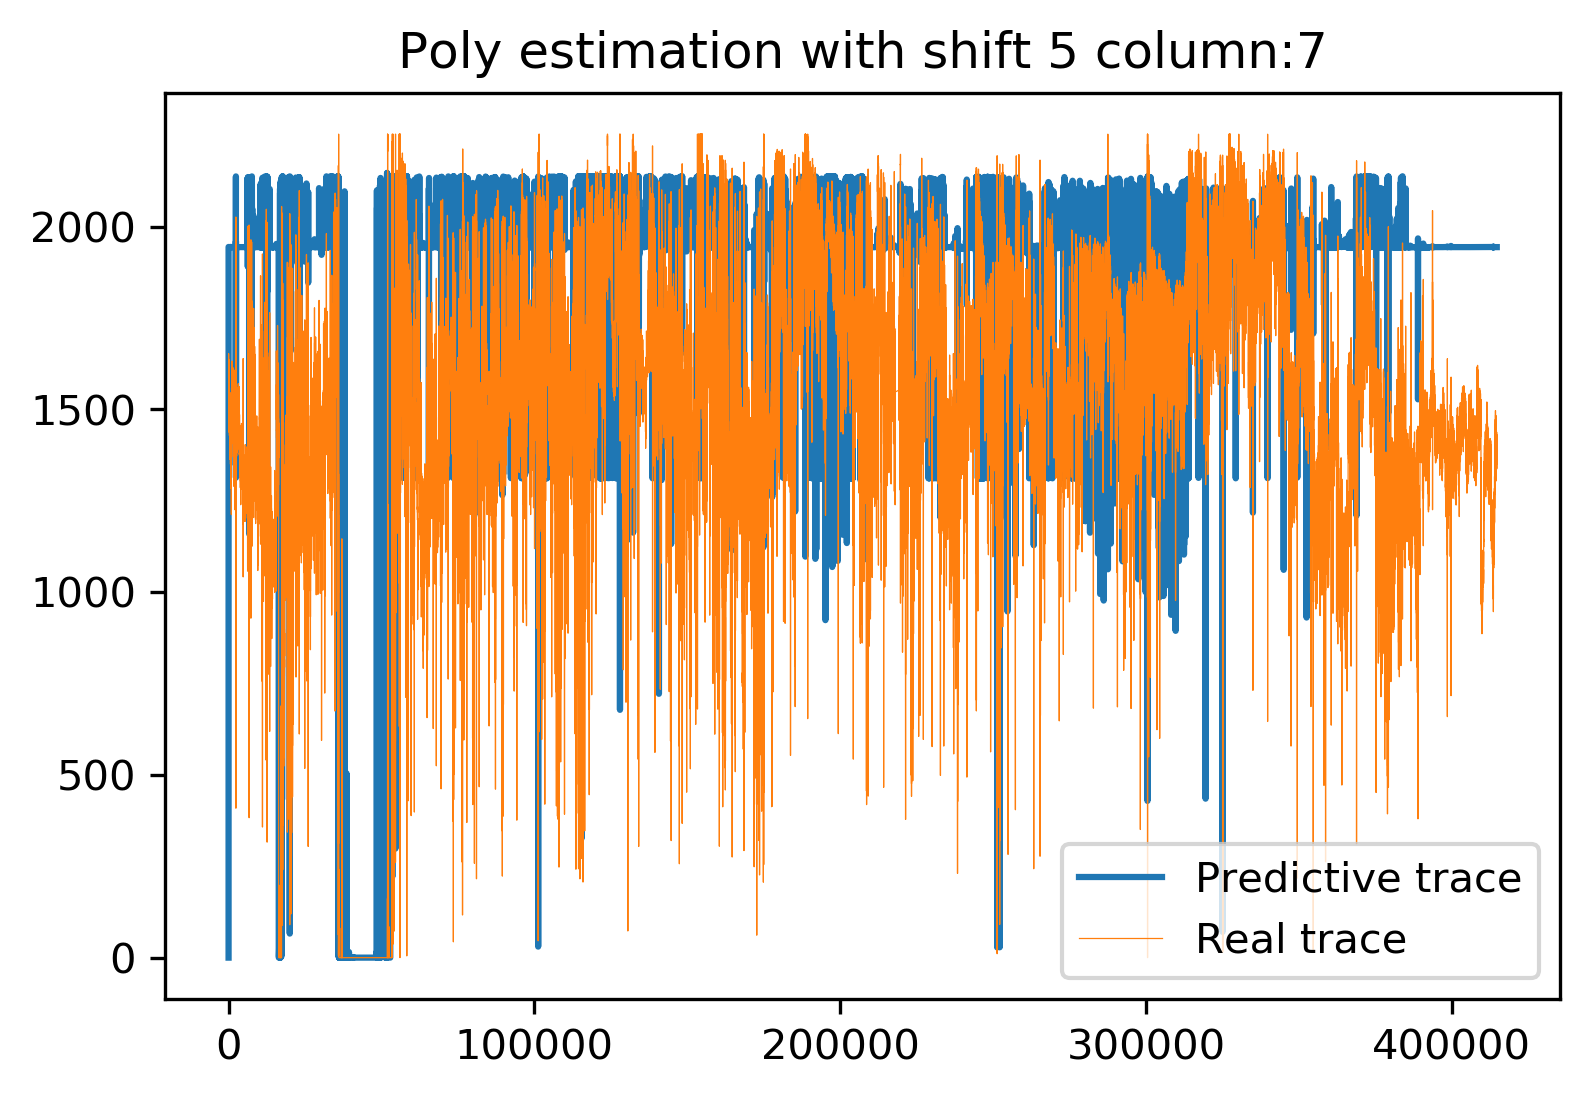

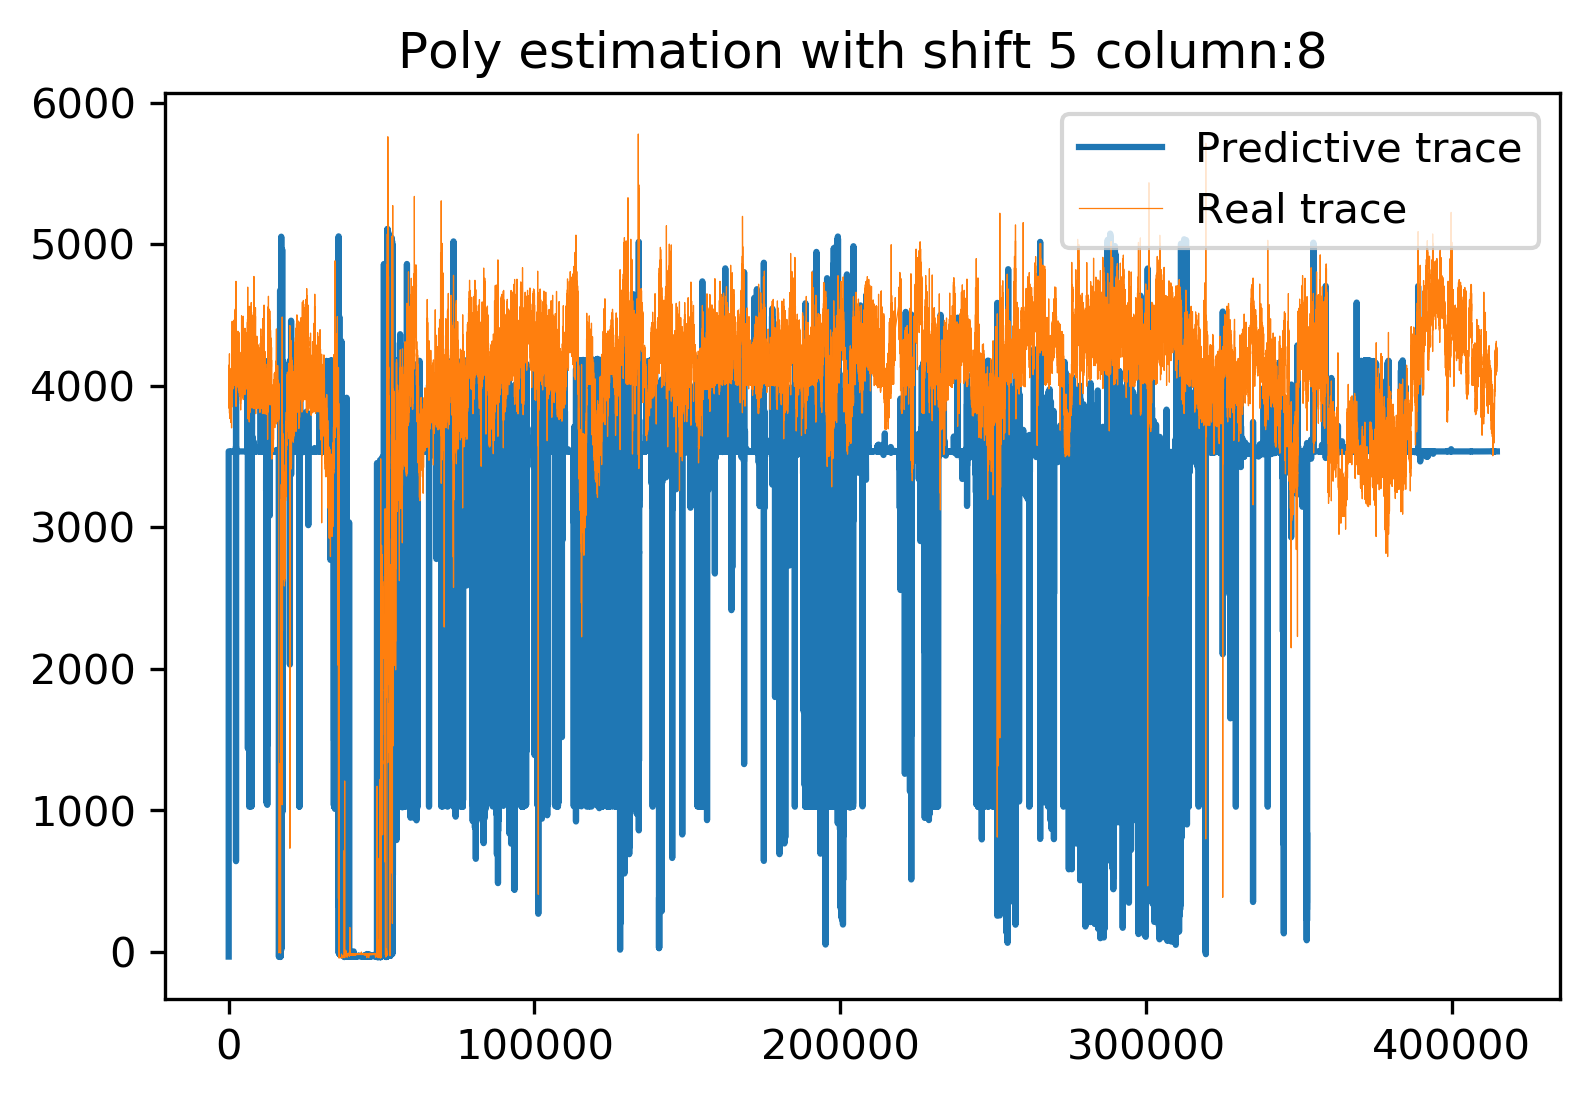

In [75]:
plot_all_traces(predictor_trace=output_estimation,
                real_trace=output_training,
                title="Poly estimation with shift 5")

In [79]:
#column=5 #heavy naptha
column=2
#Select parameters of the plot
ini_obs=3*10**3
num_obs=1000
all_range=False
#all_range=True
if all_range:
    ini_obs=0
    num_obs=494624
state=state_names[column] #should be same of variable name above
print(state)

14QI506.PNT


Text(0.5, 1.0, 'Heavy Naphta from data')

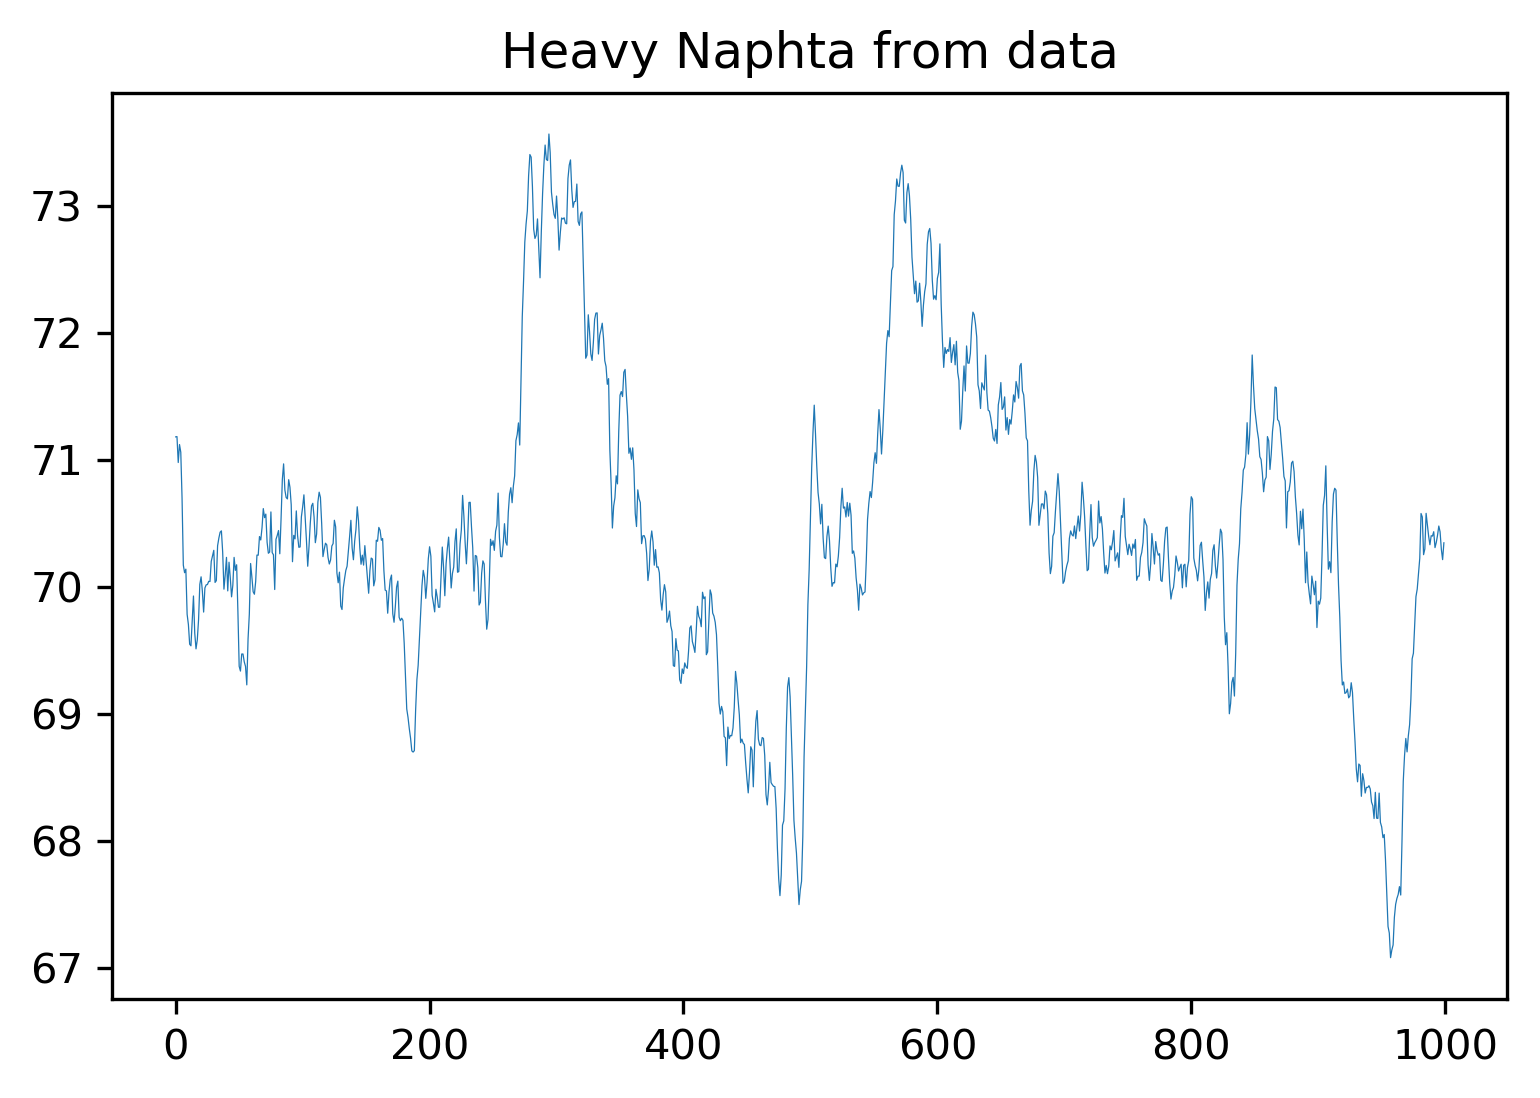

In [80]:
#Plot data
plt.plot(output_training[ini_obs:ini_obs+num_obs,column],label='Real trace',linewidth=0.3)
plt.title('Heavy Naphta from data')

Text(0.5, 1.0, 'Heavy Naphta from estimation')

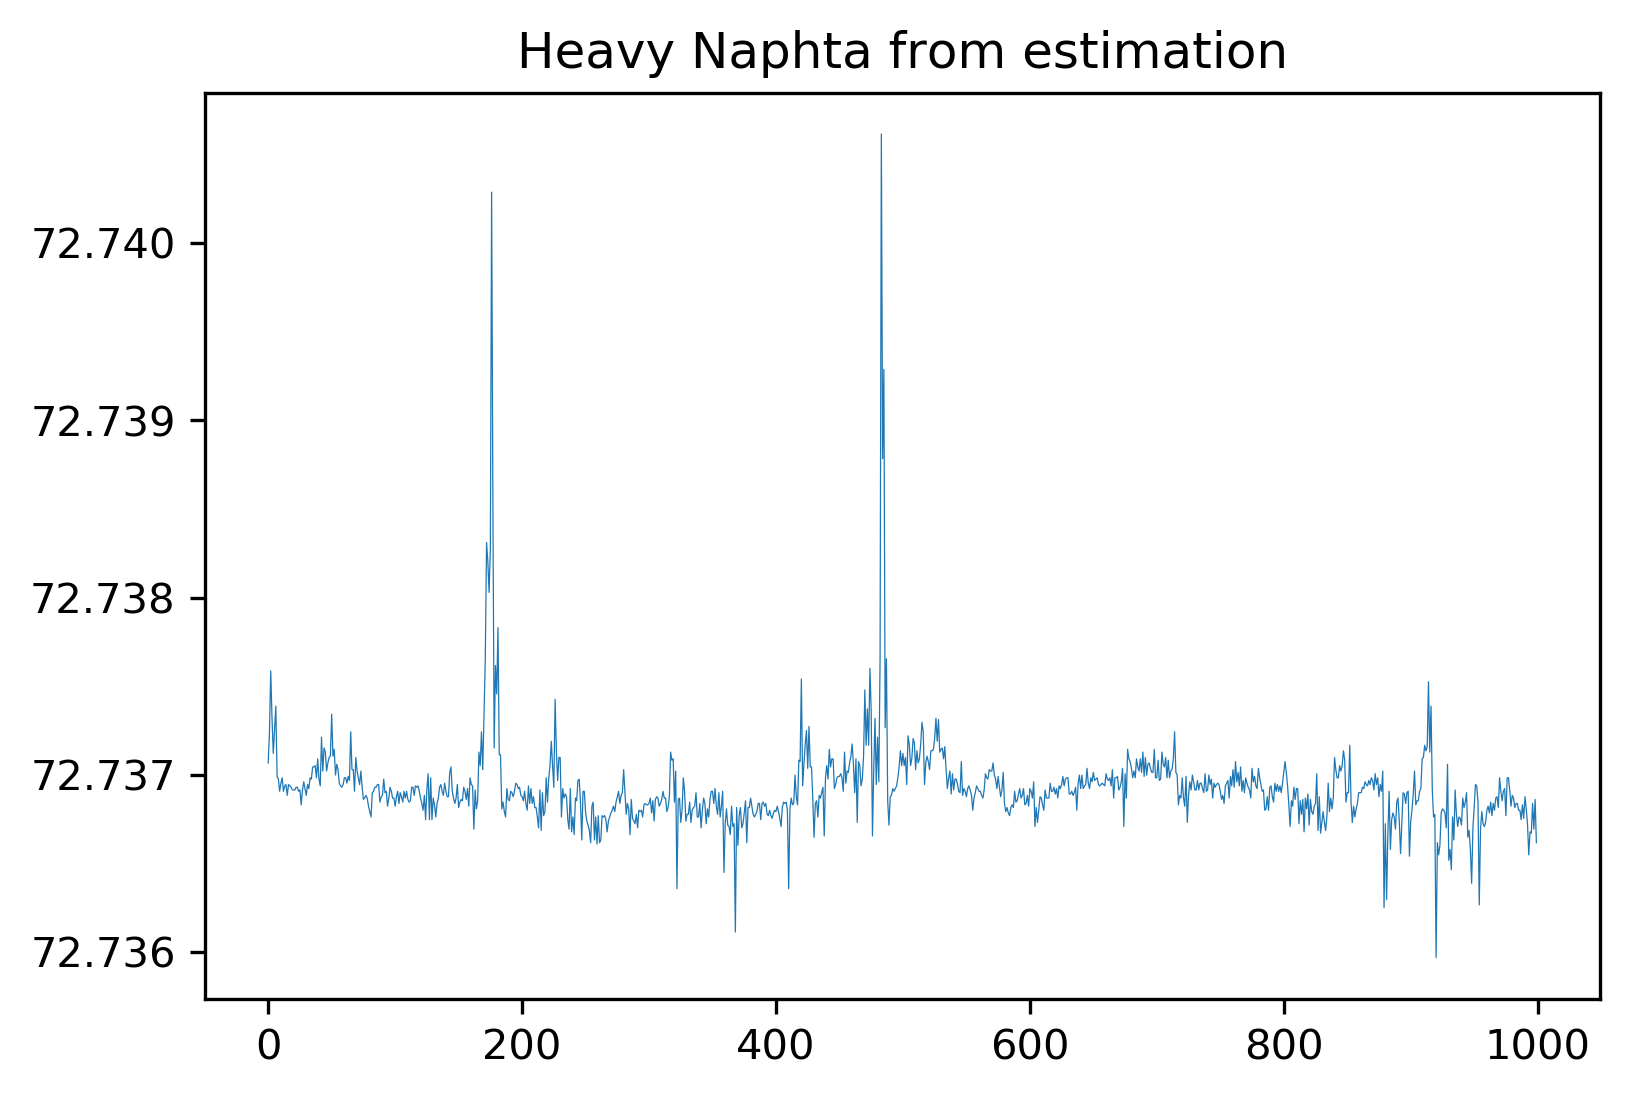

In [81]:
#Plot prediction
plt.plot(output_estimation[ini_obs:ini_obs+num_obs,column],label='Real trace',linewidth=0.3)
plt.title('Heavy Naphta from estimation')

In [ ]:
observation=500
input_s = states_input[observation,:] #get input from dataset
state = predictor.predict(state=input_s,action=actions_input[observation,:]) #estimate diff or state

In [ ]:
state[column]

In [ ]:
output_training[observation][column]